Ray tracing is a modern technique to model the transportation of light. However, mostly used in pre-rendered applications; it is now making its way into video games. By its core ray tracing is an intensive task, often this term is keyed as "expensive". Therefore, to, increase the accessibility of video games to computers with a lower specification it is important to optimize light casting while retaining good results. 

The time complexity of ray tracing depends on the number of rays, objects in the scene, and the iterations of tests. For this visualization, let variables: \($n$\) be number of object(s), \($r$\) be number of ray cast(s), and \($k$\) be cost of intersection test(s) for a single object. The current method of ray tracing adopted is Naive Ray Tracing, which states: for every ray, the algorithm tests all \($n$\) objects. The time complexity of the aforementioned can be plotted as such:


$$ {Time Complexity} = o(r \cdot n \cdot k)\ $$


On the other side of the spectrum, flood fill for lighting is a technique used to simulate light propagation by treating light as a "filling" process across a grid or scene. It starts from a light source and spreads outward to connected regions, filling areas within a certain distance or until blocked by obstacles. The algorithm typically uses depth-first search (DFS) or breadth-first search (BFS) to determine which areas are illuminated, making it suitable for simple 2D or voxel-based environments where realistic lighting isn't required. For this visualization, let variables: \($n$\) be number of pixels (or nodes) in the region to fill and \($m$\) be number of edges in the graph/grid.




| Algorithm         | Time Complexity (Naive)          | Time Complexity (Optimized)         |
|-------------------|----------------------------------|-------------------------------------|
| Ray Tracing  | $( o(r \cdot n \cdot k) )$       | $( o(r \cdot \log(n) \cdot k) )$     |
| Flood Fill    | $( o(n) ) \ or \ ( o(w \cdot h) )$ | N/A (typically not optimized further) |




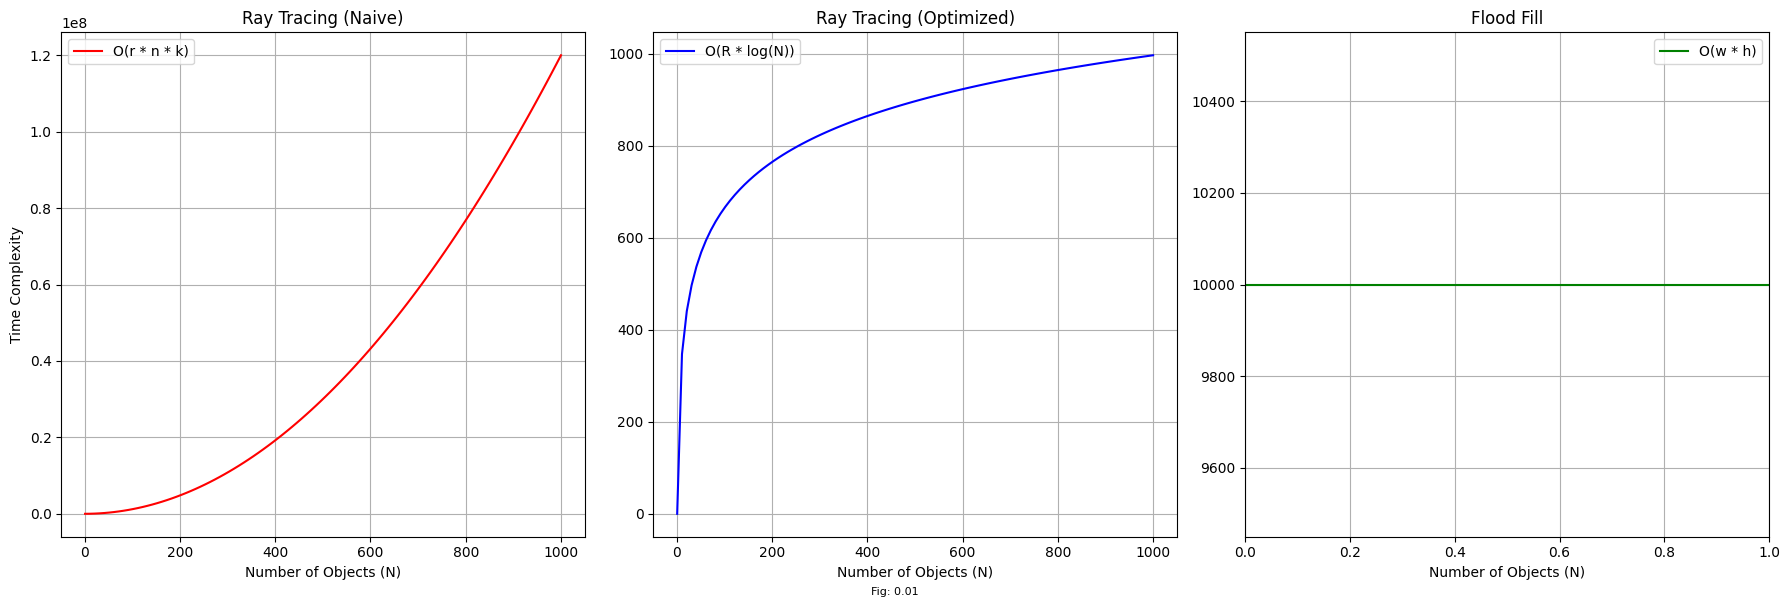

In [122]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
K = 10
O = 12
N = np.linspace(1, 1000, 100)  # Number of objects
R = 100                       # Number of rays
w, h = 100, 100               # Grid dimensions for flood fill
n = w * h                     # Total grid size

# Time complexity formulas
ray_tracing_naive = O * (N * N * K)
ray_tracing_optimized = R * np.log2(N)
flood_fill = w * h

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # 1 row, 3 columns of subplots

# Plot Ray Tracing (Naive)
axes[0].plot(N, ray_tracing_naive, label="O(r * n * k)", color="red")
axes[0].set_title("Ray Tracing (Naive)")
axes[0].set_xlabel("Number of Objects (N)")
axes[0].set_ylabel("Time Complexity")
axes[0].legend()
axes[0].grid(True)

# Plot Ray Tracing (Optimized)
axes[1].plot(N, ray_tracing_optimized, label="O(R * log(N))", color="blue",)
axes[1].set_title("Ray Tracing (Optimized)")
axes[1].set_xlabel("Number of Objects (N)")
axes[1].legend()
axes[1].grid(True)

# Plot Flood Fill
axes[2].axhline(flood_fill, label="O(w * h)", color="green",)
axes[2].set_title("Flood Fill")
axes[2].set_xlabel("Number of Objects (N)")
axes[2].legend()
axes[2].grid(True)

# Adjust layout

plt.figtext(0.5, 0, "Fig: 0.01", wrap=True, horizontalalignment='center', fontsize=8)
plt.tight_layout()  # Ensure proper spacing between plots
plt.show()



As seen in Figure 0.01 the time complexity of ray tracing is exponential, and is, therefore, expensive. To prevent this we can either:
1. Optimize the ray tracing algorithm by iterating over static non-updating objects and assigning a "skip" flag for the compute shader to ignore. However, this approach has limitations, creating a flag would populate the PCB bus with unnecessary effects and triggers that would further worsen the performance of other non-CPU dependent computational loads. Alternatively, "baking" in shadows for an immobile object is a viable option for real-time jobs with static weather and lighting effects as the need to compute shadows every frame is redundant. This, obviously has its own set of limitations, most notable of which are an unrealistic weather and lighting cycle, as well as, non-disruptive shadows without excessive math and collision testing. This is why a lot of graphically intensive and realistic games require strong processors and or graphic units. However, real-time rendering using ray-marching is not the only option. It is often unnecessary to use precise mapping techniques in parts of the video game where attention is not usually drawn. Therefore, it is common for competitive video game developers to approximate shadow rending in favor of ray-tracing. However, approximation at the end of the day is not a precise result and tends to fall apart in extreme circumstances.

To prevent that a second and very appealing option surfaces with promising results

2. Mathematical Ray Marching Approximation, or M.R.M.A is a mathematical approximation and ray marching hybrid algorithm focused on obtaining realistic shadows at a much lower computational cost, the algorithm can be defined by a group of equations: 


    $$
    S(P)_{intensity} = a \cdot S_{MSM}(P) + (1-a) \cdot S_{SDF}(P)
    $$

    1. The Moment Shadow Mapping (MSM) Component can be modeled as: 

        $$
        \mu_{1}(x,y) = \frac{1}{N}\sum_{i=1}^{N}z_{i}\\
        \mu_{2}(x,y) = \frac{1}{N}\sum_{i=1}^{N}z_{i}^{2}
        $$

        Where:
        - $(x,y)$   are light-space coordinates of the texel
        - $z_{i}$   are depth values of the geometry in light space.
        - $N$       is number of samples per texel.

        Furthermore, it is also important to model an equation to check the probability of occlusion 


        $$
        P_{occlusion}(P) =\frac{\mu_2 + d^2 - 2\mu_1 \cdot d}{\mu_2 - \mu_1^2}
        $$

        or

        $$
        P_{occlusion}(P) =\frac{\frac{1}{N}\sum_{i=1}^{N}z_{i}^{2} + d^2 - 2\frac{1}{N}\sum_{i=1}^{N}z_{i} \cdot d}{\frac{1}{N}\sum_{i=1}^{N}z_{i}^{2} - \left(\frac{1}{N}\sum_{i=1}^{N}z_{i}\right)^2}
        $$

    2. Signed Distance Fields (SDF) Component

        
        The Signed Distance Field (SDF) defines the distance from any point $P$ to the nearest surface $Q$:

        $$
        \text{SDF}(P) = \min_{Q \in S} \|P - Q\| \cdot \text{sign}(P)
        $$

        Where:

        - $S$: The set of all surfaces in the scene.
        - $\text{sign}(P)$: 
        - $+1$ if $P$ is outside the geometry.
        - $-1$ if $P$ is inside the geometry.

        To compute local shadows, march from $P$ along the light direction $L$ in steps:

        1. Initialize $d_{\text{occlusion}} = 0$.
        2. At each step $t$, update $P_t = P + tL$.
        3. Query the SDF: $d_t = \text{SDF}(P_t)$.
        4. Accumulate $d_{\text{occlusion}}$ until:
        - $d_t < \epsilon$ (hit surface), or
        - $t > t_{\text{max}}$ (no occluder).

        The shadow intensity from the SDF is:

        $$
        S_{\text{SDF}}(P) = e^{-\beta \cdot d_{\text{occlusion}}} \cdot \cos(\theta)
        $$

        Where:

        - $\beta$: Softness control parameter.
        - $\cos(\theta) = \max(0, L \cdot N)$: The cosine of the angle between the light direction $L$ and the surface normal $N$.

   Here are few other things to keep in mind as u complete your algorithm:
   

    Preprocessing:
    1. Render the scene from the light's perspective to compute \( $\mu_1$ \) and \( $\mu_2$ \) for the shadow map.
    2. Precompute the SDF for the scene geometry. <br>

    Per-Pixel Shadow Calculation:
    1. Transform the pixel \( P \) into light space.
    2. Compute \($S_{MSM}(P)$\) using the MSM equations.
    3. Perform SDF-based light marching to compute \($S_{SDF}(P)$\).
    4. Blend \($S_{MSM}(P)$\) and \($S_{SDF}(P)$\) using the unified shadow equation. <br>

    Optimization:
    1. Use hierarchical grids or mipmaps for efficient SDF queries.
    2. Limit SDF refinement to areas near the camera or shadow edges. <br>


    And finally here is the completely modeled equation:

    $$
    S(P) = \sum_{i=k}^{\infty}\frac{d + k}{d} \cdot \max\left(0, 1 - \frac{\frac{1}{N}\sum_{i=1}^{N}z_{i}^{2} + d^2 - 2\frac{1}{N}\sum_{i=1}^{N}z_{i} \cdot d}{\frac{1}{N}\sum_{i=1}^{N}z_{i}^{2} - \left(\frac{1}{N}\sum_{i=1}^{N}z_{i}\right)}\right) + \left(1 - \frac{d + k}{d}\right) \cdot e^{-\beta \cdot d_\text{occlusion}} \cdot \max(0, L \cdot N) 
    $$

    The equation models light traveling through ray marching and still offers a greater performance than optimized ray tracing. The time complexity can be modeled as such: $O (R \cdot S)$ and is linear




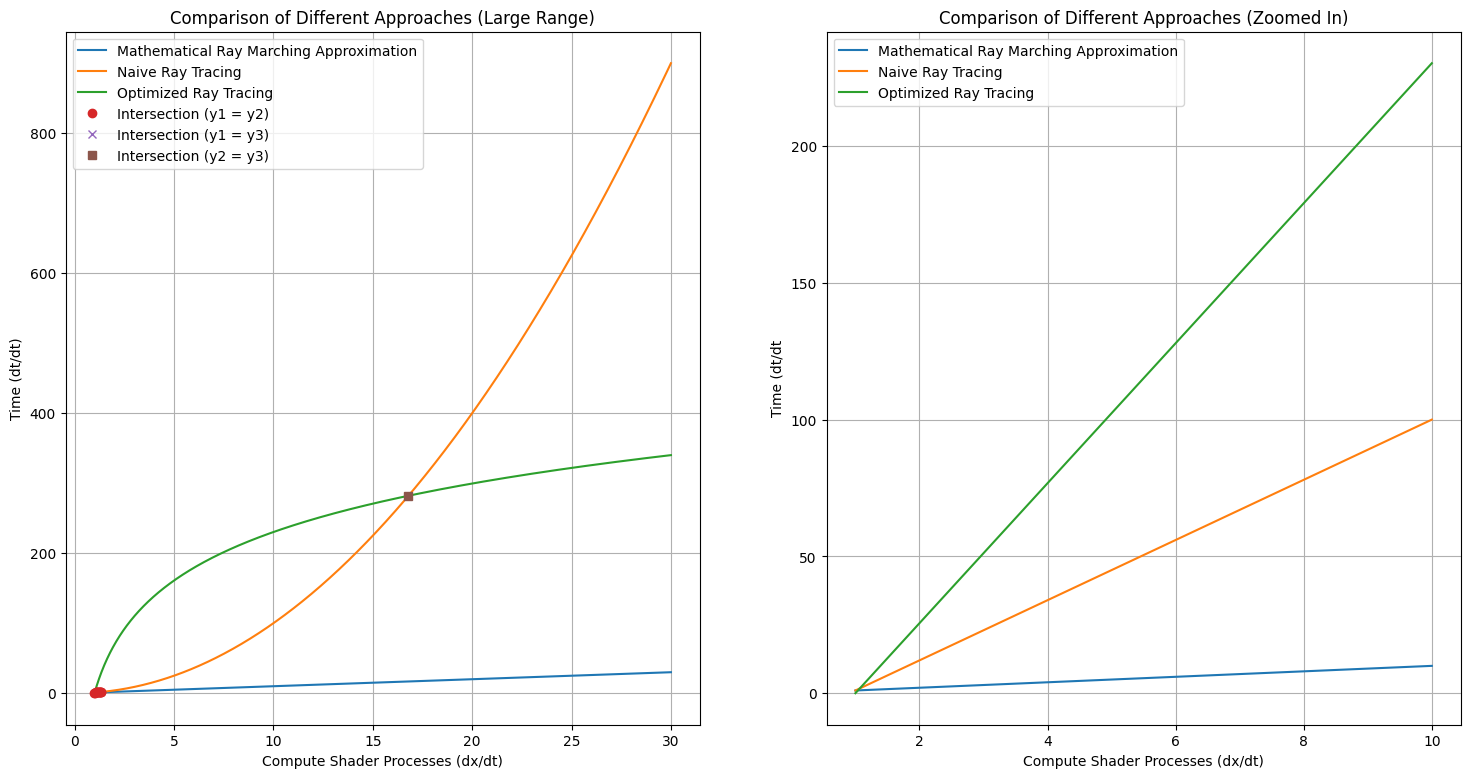

In [123]:
import numpy as np
import matplotlib.pyplot as plt

# Define the x values
x = np.linspace(1, 30, 1000)  # Avoid zero to prevent log issues
x2 = np.linspace(1, 10, 2)  # A smaller range for the second plot

tolerance = 0.5
# Define the functions for x
R = 100    
y11 = x
y21 = x**2
y31 = R * np.log(x)  # Placeholder for time complexity

# Define the functions for x2
y12 = x2
y22 = x2**2
y32 = R * np.log(x2)  # Placeholder for time complexity

# Intersection points calculation (only for the first plot, as x and x2 have different sizes)
intersection_indices_1_2 = np.where(np.abs(y11 - y21) < tolerance)[0]
intersection_indices_1_3 = np.where(np.abs(y11 - y31) < tolerance)[0]
intersection_indices_2_3 = np.where(np.abs(y21 - y31) < tolerance)[0]

# Get the x and y values at the intersection points
x_intersections_1_2 = x[intersection_indices_1_2]
y1_intersections = y11[intersection_indices_1_2]
y2_intersections = y21[intersection_indices_1_2]

x_intersections_1_3 = x[intersection_indices_1_3]
y1_intersections_3 = y11[intersection_indices_1_3]
y3_intersections = y31[intersection_indices_1_3]

x_intersections_2_3 = x[intersection_indices_2_3]
y2_intersections_3 = y21[intersection_indices_2_3]
y3_intersections_2_3 = y31[intersection_indices_2_3]

# Create a figure and axes using subplots
fig, axes = plt.subplots(1, 2, figsize=(18,9))  # Correct use of subplots

# Create the plot on the first subplot (for x with 1000 points)
axes[0].plot(x, y11, label='Mathematical Ray Marching Approximation')  # Line for y = x
axes[0].plot(x, y21, label='Naive Ray Tracing')  # Line for y = x^2
axes[0].plot(x, y31, label='Optimized Ray Tracing')  # Line plot for time complexity

# Add markers only at the intersection points
axes[0].plot(x_intersections_1_2, y1_intersections, 'o', label='Intersection (y1 = y2)')  # 'o' markers
axes[0].plot(x_intersections_1_3, y1_intersections_3, 'x', label='Intersection (y1 = y3)')  # 'x' markers
axes[0].plot(x_intersections_2_3, y2_intersections_3, 's', label='Intersection (y2 = y3)')  # 's' markers

# Create the plot on the second subplot (for x2 with 10 points)
axes[1].plot(x2, y12, label='Mathematical Ray Marching Approximation')  # Line for y = x2
axes[1].plot(x2, y22, label='Naive Ray Tracing')  # Line for y = x2^2
axes[1].plot(x2, y32, label='Optimized Ray Tracing')  # Line plot for time complexity

# Add markers for intersections (if any)
# Since there are fewer points, intersection detection may not be valid here, so it's skipped
# Add markers only at the intersection points if needed

# Label the axes
axes[0].set_xlabel('Compute Shader Processes (dx/dt)')
axes[0].set_ylabel('Time (dt/dt)')
axes[1].set_xlabel('Compute Shader Processes (dx/dt)')
axes[1].set_ylabel('Time (dt/dt')

# Add a title for the first subplot
axes[0].set_title('Comparison of Different Approaches (Large Range)')
axes[1].set_title('Comparison of Different Approaches (Zoomed In)')
# Show the legend for both subplots
axes[0].legend()
axes[1].legend()

# Show the grid for both subplots
axes[0].grid(True)
axes[1].grid(True)

# Show the plot
plt.show()


However, the aforementioned equations only deal with shadows and are not inclusive of other aspects often associated with Ray Tracing, such as, specular highlghts, normal maps, refraction, and defraction. Lets first tackle with the most computtionally expensive task, refraction.

Let's first start with understand how refraction works at it's core. The point of refraction can be defined with Snell's Law:

$$ n_i\cdot\sin\theta_i=n_f\cdot\sin\theta_f$$
<br><br><br>

Which can be visualized as such. 

The line between the vaccum and medium can be represented as $S_n$, or the surfce normal. where the shift in the ray (angle of incidient) is called the Index of Refraction (IOR) and can be represented as $\theta$ this number is modified by $n$ in the formula above and is independent to each medium.

![alt text](IMG_0237.jpeg)

However, doing trignometric functions on a GPU shader can be extremely slow due to its low clock-speed, high quantity core set-up. To mitigate this problem we can sub in the taylor's series for $\sin\theta$:

$$\sin x = \sum_{n=0}^{\infty} \hspace{0.2em} (-1)^n \frac{x^(2n+1)}{(2n+1)!} \quad for \quad |x| \hspace{0.5em} \leq \hspace{0.5em} z$$

However, this is only for case zero, assuming that the angle of attack is not critical or negative

to deal with those exceptions let us set up a piecewise function, which can be modeled using a switch case model. 

let the function modeled be $f(x)$

$$
f(x) \hspace{0.5em} = \hspace{0.5em} 

\sin x \hspace{0.5em} = \hspace{0.5em} \sum_{n=0}^{\infty} \hspace{0.2em} (-1)^n \frac{x^(2n+1)}{(2n+1)!} \quad for \quad |x| \hspace{0.5em} \leq \hspace{0.5em} 1 \\

\theta_{critical} \hspace{0.5em} = \hspace{0.5em} 0 \quad for \quad \hspace{0.5em} \theta_{critical} \hspace{0.5em} = \hspace{0.5em} \arcsin(x) \hspace{0.5em} \Rightarrow \hspace{0.5em} \arcsin\left(\frac{n_f}{n_i}\right) \hspace{0.5em} \Rightarrow \hspace{0.5em} \sum_{n=0}^a \hspace{0.3em} \frac{(2n)!}{2^2n \cdot (n!)^2 \cdot (2n+1)} \cdot 2n+1\\

-\sin x \hspace{0.5em} = \hspace{0.5em} \sum_{n=0}^{\infty} \hspace{0.2em} (-1)^n \frac{x^(2n+1)}{(2n+1)!} \quad for \quad x \hspace{0.5em} \leq \hspace{0.5em} 0 \\
$$

The conversion from an $\arcsin$ into a taylor's seris function is extremeley benifical in hardware acceleration based workloads where a Graphics Processing Unity (GPU) pipeline with multiple low boost clock cores are doing (a)synchronus tasks to reudce at real time rendering costs.

the equation of diffrence can be modeled using an integral between the diffrence of the two equations, in a high fidelity real time computational load the time complexity of the functions can be modeled as such:

$$T_{taylor} \hspace{0.5em} = \hspace{0.5em} O(n)$$

whilst, raw computation of arcsin using something like the Newton-Rhapson algorithim or the CORDIC is possible it creates a logarythimic time complexity which can be modeled as such:

$$T_{CORDIC} \hspace{0.5em} = \hspace{0.5em} O(\log_z(m))$$

As mentioned before the diffence in computations can be modeled using the integral of the two previous functions, which can be modeled as such: 

Note: the use of symbol $\phi$ (phi) in this case is to display an optional use case

$$ C_{diffrence} = \displaystyle \int\limits_{a_\phi}^{b_\phi} \hspace{0.2em} \left(T_{taylor}(x) - T_{CORDIC}(x)\right) \, dx $$


